The Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, we need to predict the number of taxi orders for the next hour. Build a model for this prediction.

The value of the * RMSE * metric on the test sample should be no more than 48.

# 1.About data

In [1]:
#library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#check data
taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
display(taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
#resampling 1 hour
new_taxi = taxi.resample('1H').sum()
new_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Conclusion

We had 26496 entries before we combined the data by the hour to get 4416 entries. There is only one column - the number of orders, it is also the target.

We do not check for zeros / duplicates, because we immediately changed the column with the date into an index.

# 2. Analyze

In [5]:
#check chonology
new_taxi = new_taxi.sort_index()
display(new_taxi.index.is_monotonic)

True

In [6]:
#min and max date
display(new_taxi.index.min(), new_taxi.index.max())

Timestamp('2018-03-01 00:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

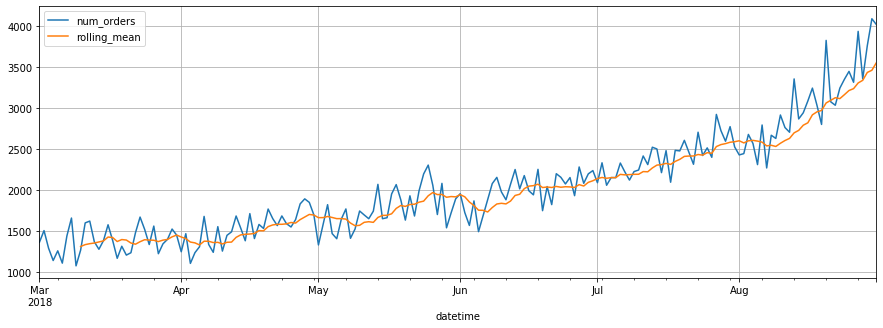

In [7]:
#check rolling
taxi.sort_index(inplace=True)
for_analyze = taxi['2018-03-01':'2018-08-31'].resample('1D').sum()
for_analyze['rolling_mean'] = for_analyze.rolling(10).mean()
for_analyze.plot(figsize=(15,5), grid = True)

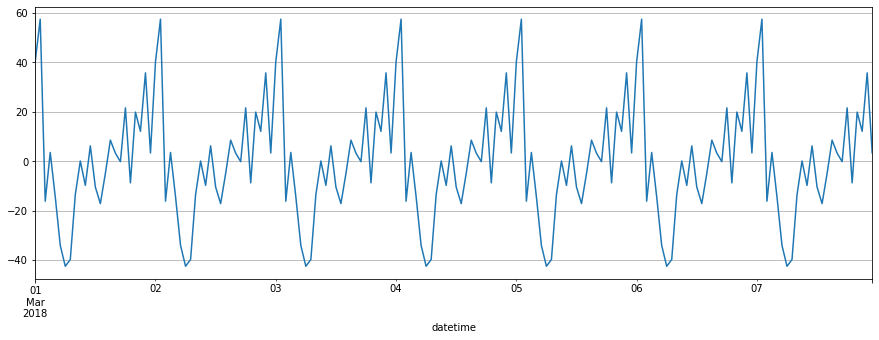

In [8]:
#check seasonal for 1 week(1 hour)
taxi.sort_index(inplace=True)
for_analyze = taxi['2018-03-01':'2018-03-07'].resample('1H').sum()

decomposed = seasonal_decompose(for_analyze)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(15,5), grid = True)

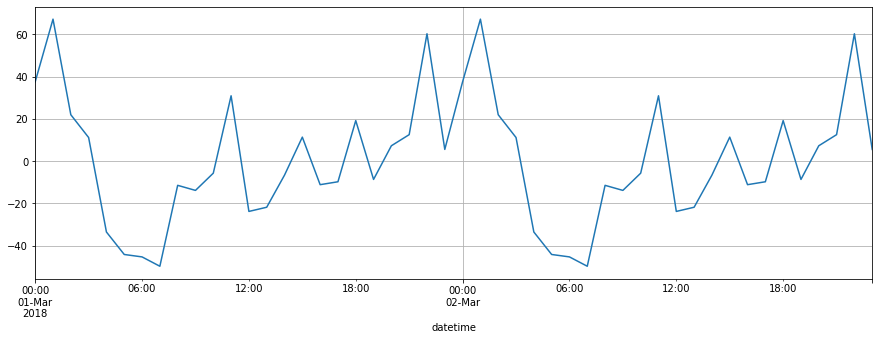

In [9]:
#check seasonal for 1 day(1 hour)
taxi.sort_index(inplace=True)
for_analyze = taxi['2018-03-01':'2018-03-02'].resample('1H').sum()

decomposed = seasonal_decompose(for_analyze)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15,5), grid = True)

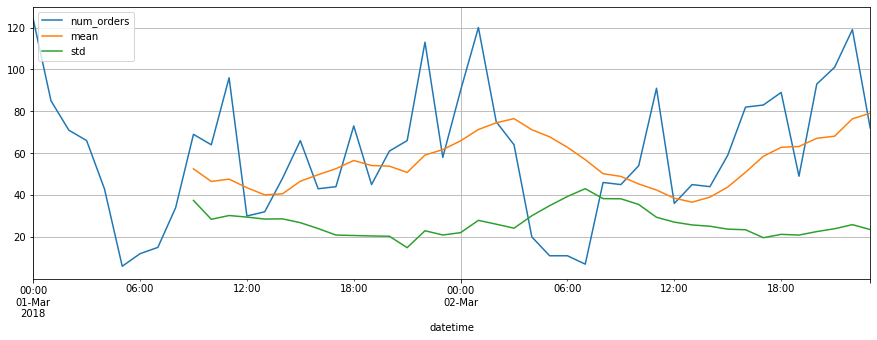

In [10]:
#check std
for_analyze['mean'] = for_analyze['num_orders'].rolling(10).mean()
for_analyze['std'] = for_analyze['num_orders'].rolling(10).std()
for_analyze.plot(figsize=(15,5), grid = True)

### Conclusion

So we checked the chronology and it was correct, great.

For the charts, we found out the minimum and maximum dates. Our period  from March 1, 2018 to August 31, 2018.

The rolling tells us that July and August are popular times at airports. Most often, people fly on vacation during these months, so on average there are more orders.

With seasonality, we can see popular hours: evening and late morning.

Standard deviation do not change.

# 3. Train

In [11]:
#make features
def make_features(new_taxi, max_lag, rolling_mean_size):
    new_taxi['dayofweek'] = new_taxi.index.dayofweek
    new_taxi['hour'] = new_taxi.index.hour
    
    for lag in range(1, max_lag + 55):
        new_taxi['lag_{}'.format(lag)] = new_taxi['num_orders'].shift(lag)

    new_taxi['rolling_mean'] = new_taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(new_taxi, 1, 1)

In [12]:
#divide for two
train_valid, test  = train_test_split(new_taxi, shuffle=False, test_size=0.1)

#and three
train, valid = train_test_split(train_valid, shuffle=False,test_size=0.1111)

#drop
train = train.dropna()
valid = valid.dropna()
test = test.dropna()

print(train.shape)
print(valid.shape)
print(test.shape)

(3477, 59)
(442, 59)
(442, 59)


In [13]:
#features & target
features_train = train.drop(['num_orders'] , axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'] , axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'] , axis=1)
target_test = test['num_orders']

In [14]:
#params n_estimators RandomForestRegressor
for est in range(10, 21):
    model =  RandomForestRegressor(random_state=12345, n_estimators = est)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predicted_valid))**0.5
    print("max_est =", est, ": ", end='')
    print("rmse:", rmse)

max_est = 10 : rmse: 33.02029781624181
max_est = 11 : rmse: 32.926969412402876
max_est = 12 : rmse: 33.027444519721286
max_est = 13 : rmse: 32.97636549322461
max_est = 14 : rmse: 32.81637637111911
max_est = 15 : rmse: 32.61781800308002
max_est = 16 : rmse: 32.612809458563106
max_est = 17 : rmse: 32.602454020236955
max_est = 18 : rmse: 32.6609336355365
max_est = 19 : rmse: 32.58749576693468
max_est = 20 : rmse: 32.632992684374834


In [15]:
#params LightGBM max_depth
for depth in range(5, 16):
    model =  LGBMRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predicted_valid))**0.5
    print("max_depth =", depth, ": ", end='') 
    print("rmse:", rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
max_depth = 5 : rmse: 30.70505751331873
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
max_depth = 6 : rmse: 30.804348842401325
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
max_depth = 7 : rmse: 29.859409183525734
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
max_depth = 8 : rmse: 30.447772145977336
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
max_depth = 9 : rmse: 30.52667354981249
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
max_depth = 10 : rmse: 30.966043598495787
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
max_depth = 11 : rmse: 30.341849503003992

In [16]:
#params LightGBM num_leaves
for nl in range(15, 26):
    model =  LGBMRegressor(random_state=12345, num_leaves=nl)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predicted_valid))**0.5
    print("num_leaves =", nl, ": ", end='') 
    print('RMSE:', rmse)

num_leaves = 15 : RMSE: 30.70075342707762
num_leaves = 16 : RMSE: 30.970516015756854
num_leaves = 17 : RMSE: 30.80796373290924
num_leaves = 18 : RMSE: 30.305224506336774
num_leaves = 19 : RMSE: 30.348638941693533
num_leaves = 20 : RMSE: 30.247062644874585
num_leaves = 21 : RMSE: 30.4079185710096
num_leaves = 22 : RMSE: 30.195464642175306
num_leaves = 23 : RMSE: 30.907349327023546
num_leaves = 24 : RMSE: 30.50025860580718
num_leaves = 25 : RMSE: 30.550518407951305


In [17]:
#params LightGBM min_data_in_leaf
for min_data in range(5, 16):
    model = LGBMRegressor(random_state=12345, min_data_in_leaf=min_data)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predicted_valid))**0.5
    print("min_data_in_leaf =", min_data, ": ", end='') 
    print('RMSE:', rmse)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
min_data_in_leaf = 5 : RMSE: 31.358491172539853
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
min_data_in_leaf = 6 : RMSE: 31.64432145976845
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
min_data_in_leaf = 7 : RMSE: 30.86013657369916
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
min_data_in_leaf = 8 : RMSE: 30.69706996794094
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
min_data_in_leaf = 9 : RMSE: 31.3371125610383
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
min_data_in_leaf = 10 : RMSE: 30.6275741781

In [18]:
#function for train
def regression_model(models):
    model = models
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predicted_valid))**0.5
    print("rmse:", rmse)

In [19]:
#train LinearRegression
regression_model(LinearRegression())

rmse: 31.73087918647281


In [20]:
#train RandomForestRegressor
regression_model(RandomForestRegressor(random_state=12345, n_estimators = 19))

rmse: 32.58749576693468


In [21]:
#train LGBMRegressor
regression_model(LGBMRegressor(random_state=12345,max_depth=11, max_bin=20, min_data_in_leaf = 11,num_leaves=25))

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
rmse: 30.705655531068228


### Conclusion

The parameters was calculated and we get the following result:
- rmse LinearRegression 31.73
- rmse RandomForestRegressor 32.58
- rmse LGBMRegressor 30.71

Winner - LGBMRegressor.

All values are less than 48, but LGBM is smallest.


Let's check all.

# 4. Test

In [22]:
#function for test
def regression_model_test(models_test):
    model = models_test
    model.fit(features_train, target_train)
    predicted_test = model.predict(features_test)
    rmse = (mean_squared_error(target_test,predicted_test))**0.5
    print("rmse:", rmse)

In [23]:
#test LinearRegression
regression_model_test(LinearRegression())

rmse: 42.212216741472766


In [24]:
#test RandomForestRegressor
regression_model_test(RandomForestRegressor(random_state=12345, n_estimators = 15))

rmse: 47.86243652978946


In [25]:
#test LGBMRegressor
regression_model_test(LGBMRegressor(random_state=12345,max_depth=11, max_bin=20, min_data_in_leaf = 11,num_leaves=16))

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
rmse: 46.38438057036509


### Final сonclusion
So:
- rmse LinearRegression 42.21
- rmse RandomForestRegressor 47.86
- rmse LGBMRegressor 46.38

It turned out that Linear Regression showed the best reading, it has an average error of 42.21. 
But again, all rmse less than the required 48, great.